**On importe les packages et on lit l'image dont on veut extraire le texte**

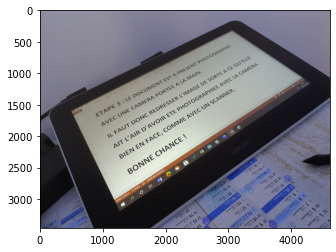

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import imutils

image = cv2.imread('image4.jpg')
plt.imshow(image)

**On extrait les contours de la zone contenant le texte**

In [2]:
# load the query image, compute the ratio of the old height
# to the new height, clone it, and resize it
ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image,height=400)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

In [3]:
# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [4]:
# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.015 * peri, True)
	#print(approx)
    # if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

In [5]:
print(screenCnt)

[[[492 130]]

 [[351  38]]

 [[ 58 188]]

 [[148 368]]]


In [6]:
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3) 
cv2.imshow("image cadree", image) 
cv2.waitKey(0)

-1

**On recadre l'image en fonction des coins de la zone contenant le texte**

In [7]:
import math
import cv2
import scipy.spatial.distance
import numpy as np

#rows est une variable contenant la hauteur de l'image, cols content sa largeur
(rows,cols,_) = image.shape

#On trouve le centre de l'image
u0 = (cols)/2.0
v0 = (rows)/2.0

#On initialise une liste qui contient les coordonnees des 4 coins du plus grand rectangle de l'image 
#(trouvé à l'étape précédente)
#p[0] = coin supérieur gauche
#p[1] = coin supérieur droit
#p[2] = coin inférieur gauche
#p[3] = coin inférieur droit
p = []
p.append((screenCnt[2][0][0],screenCnt[2][0][1]))
p.append((screenCnt[1][0][0],screenCnt[1][0][1]))
p.append((screenCnt[3][0][0],screenCnt[3][0][1]))
p.append((screenCnt[0][0][0],screenCnt[0][0][1]))

#On calcule la distance euclidienne entre les coins supérieurs gauche et droit, et entre les coins inférieur gauche et droit
#w1 et w2 correspondent à la largeur de la nouvelle image recadrée (w1 : largeur entre les coins supérieurs, 
#w2 : largeur entre les coins inférieurs).
w1 = scipy.spatial.distance.euclidean(p[0],p[1])
w2 = scipy.spatial.distance.euclidean(p[2],p[3])

#de la même manière, on calcule la hauteur de la nouvelle image (h1 entre les coins à gauche, h2 entre les coins à droite)
h1 = scipy.spatial.distance.euclidean(p[0],p[2])
h2 = scipy.spatial.distance.euclidean(p[1],p[3])

#Etant donné que nous avons deux hauteurs et deux largeurs, on prend la hauteur et la largeur maximales 
#pour être sur de na pas perdre d'information
w = max(w1,w2)
h = max(h1,h2)

#On calcule le ratio entre la largeur et la hauteur
ar_vis = float(w)/float(h)

#On transforme les coins en numpy array pour pouvoir faire plus facilement des opérations dessus
m1 = np.array((p[0][0],p[0][1],1)).astype('float32')
m2 = np.array((p[1][0],p[1][1],1)).astype('float32')
m3 = np.array((p[2][0],p[2][1],1)).astype('float32')
m4 = np.array((p[3][0],p[3][1],1)).astype('float32')

#On calcule la distance focale

k2 = np.dot(np.cross(m1,m4),m3) / np.dot(np.cross(m2,m4),m3)
k3 = np.dot(np.cross(m1,m4),m2) / np.dot(np.cross(m3,m4),m2)

n2 = k2 * m2 - m1
n3 = k3 * m3 - m1

n21 = n2[0]
n22 = n2[1]
n23 = n2[2]

n31 = n3[0]
n32 = n3[1]
n33 = n3[2]

f = math.sqrt(np.abs( (1.0/(n23*n33)) * ((n21*n31 - (n21*n33 + n23*n31)*u0 + n23*n33*u0*u0) +
                                         (n22*n32 - (n22*n33+n23*n32)*v0 + n23*n33*v0*v0))))

A = np.array([[f,0,u0],[0,f,v0],[0,0,1]]).astype('float32')

At = np.transpose(A)
Ati = np.linalg.inv(At)
Ai = np.linalg.inv(A)

#On calcule le réel ratio entre la largeur et la hauteur
ar_real = math.sqrt(np.dot(np.dot(np.dot(n2,Ati),Ai),n2)/np.dot(np.dot(np.dot(n3,Ati),Ai),n3))

#On initialise la hauteur et la largeur de la nouvelle image en fonction du ratio calculé précédemment
if ar_real < ar_vis:
    W = int(w)
    H = int(W / ar_real)
else:
    H = int(h)
    W = int(ar_real * H)

pts1 = np.array(p).astype('float32')
pts2 = np.float32([[0,0],[W,0],[0,H],[W,H]])

#La matrice M correspond à la matrice de transformation de l'image en fonction des nouveaux coins et des nouvelles mesures
M = cv2.getPerspectiveTransform(pts1,pts2)

#Cette fonction applique la matrice de transformation à l'image
#dst est notre image finale redressée et recadrée
dst = cv2.warpPerspective(image,M,(W,H))

cv2.imshow('dst',dst)
cv2.imwrite('dst.jpg',dst)
cv2.imwrite('proj.png',dst)

cv2.waitKey(0)

-1

**On extrait le texte de l'image**

*Avec Tesseract*

In [8]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
from pytesseract import image_to_string

#Cette ligne me permet d'utiliser l'outils tesseract, la changer en fonction de l'emplacement de tesseract.exe sur votre ordinateur
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def get_string(img_path):
    
    # Lire l'image avec openCV
    img = cv2.imread(img_path)

    # Convertir l'image en niveau de gris
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Effectuer des traitements sur l'image pour enlever le bruit
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)

    #  On applique une seuil pour avoir uniquement une image en noir et blanc
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

    # On enregistre l'image après avoior effectué toutes ces modifications
    cv2.imwrite("thres.png", img)

    # Reconnaissance du texte avec tesseract
    result = pytesseract.image_to_string(Image.open("thres.png"))

    return result



print('--- Start recognize text from image ---')

print(get_string("dst.jpg"))
txt = get_string("dst.jpg")

print("------ Done -------")

--- Start recognize text from image ---
8 ee a mi TE rr,

 

ETAPE 3: LE DOCUMENT EST A PRESENT PHOTOGRAPHEE
AVEC UNE CAMERA PORTEE ALA MAIN,

iL FAUT DONC REDRESSER L'IMAGE DE SORTE A CE QU'ELEE
AIT L'AIR D/AVOIR ETE PHOTOGRAPHIEE AVEC 4A CAMERA,
BIEN EN FACE, COMME AVEC UN SCANNER.

BONNE CHANCE I

 

------ Done -------


*Avec EasyOCR*

In [9]:
import matplotlib.pyplot as plt
import cv2
import easyocr
from pylab import rcParams
%matplotlib inline

def reconize_text(imag_path):
    reader = easyocr.Reader(['en'])
    return reader.readtext(imag_path)

resultat = reconize_text('dst.jpg')

print(resultat)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[35, 31], [79, 31], [79, 47], [35, 47]], 'ETAPE', 0.998675199430464), ([[91, 33], [213, 33], [213, 49], [91, 49]], ':LE DOCUMENT EST', 0.6479945472091454), ([[225, 35], [379, 35], [379, 51], [225, 51]], 'PRESENT PHOTOGRAPHIE', 0.5071053536902849), ([[35, 57], [273, 57], [273, 77], [35, 77]], 'AVEC UNE CAMERA PorteE A LA Main:', 0.4029875169787284), ([[35, 89], [387, 89], [387, 109], [35, 109]], "IL FAUT DONC REDRESSER L'IMAGE De Sorte A Ce QU ELLe", 0.11505074623074092), ([[35, 115], [381, 115], [381, 135], [35, 135]], "Ait L'AIR D'Avoir ETe PhotograPhiEE AVEC LA CAMERA", 0.24084507580864525), ([[35, 141], [291, 141], [291, 159], [35, 159]], 'BIEN EN FACE, COMME AVEC UN SCANNER:', 0.799830633699558), ([[35, 173], [145, 173], [145, 189], [35, 189]], 'BONNE CHANCE', 0.993162006774032)]


**On enregistre le texte au format txt dans un fichier "monfichier.txt"**

In [10]:
file = open("monfichier.txt","w")
file.write(txt)
file.close()